# Computer vision with seedlings

Seedlings are heavily competing for nutrients and water and often this phase is crucial for a plant to prevail against all other seedlings. Consequently it can be of advantage in agriculture to automatically detect wild and cultivated plants. By eliminating wild plant in the early growth state of the plant one might be able to reduce crop losses in the end. Let's explore how computer vision and machine learning can help to solve this task. For this purpose we can use [this research image dataset](https://vision.eng.au.dk/plant-seedlings-dataset/) with 12 different common species in Danish agriculture of cultivated and wild plants.

<img src="https://cdn.pixabay.com/photo/2014/01/31/23/25/cress-255938_1280.jpg" width="600px">


In a previous notebook we already analysed that this dataset has an unconscious target leakage. It leads to a model that learns from the size of the stones in the background to predict the plant species. In this notebook we will bypass this behaviour by extracting plant information only and thereby removing the pebble stones background.

# Loading packages

As usual we need to load some packages to get started:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from PIL import Image
from imageio import imread

import seaborn as sns
sns.set_style("dark")
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from skimage.morphology import closing, disk, opening

import cv2
import time
import copy
from tqdm import tqdm_notebook as tqdm

from os import listdir
from skimage.segmentation import mark_boundaries

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic=True

In [2]:
run_training=False

# Loading data

Let's take a look at our input folder:

In [3]:
listdir("../input")

['v2-plant-seedlings-dataset', 'seedlingsmodel', 'pretrained-pytorch-models']

You can see that I have added pretrained neural networks for solving this task.

In [42]:
base_path = "../input/v2-plant-seedlings-dataset/nonsegmentedv2/"
OUTPUT_PATH = "segmented_seedlings"
MODEL_PATH = "../input/seedlingsmodel/segmented_seedlings"
LOSSES_PATH = "../input/seedlingsmodel/"
subfolders = listdir(base_path)
subfolders

['Small-flowered Cranesbill',
 'Cleavers',
 'Loose Silky-bent',
 'Sugar beet',
 'Shepherds Purse',
 'Charlock',
 'Fat Hen',
 'Maize',
 'Scentless Mayweed',
 'Common Chickweed',
 'Black-grass',
 'Common wheat']

## Extracting image paths and target species

All target species have different subfolders. Consequently we can extract the target as well as the path for each image by collecting them for each subfolder. After doing so we end up with a pandas dataframe that holds the path, the species as well as the width and height of all images:

In [5]:
total_images = 0
for folder in subfolders:
    total_images += len(listdir(base_path + folder))

plantstate = pd.DataFrame(index=np.arange(0, total_images), columns=["width", "height", "species"])

k = 0
all_images = []
for m in range(len(subfolders)):
    folder = subfolders[m]
    
    images = listdir(base_path + folder)
    all_images.extend(images)
    n_images = len(images)
    
    for n in range(0, n_images):
        image = imread(base_path + folder + "/" + images[n])
        plantstate.loc[k, "width"] = image.shape[1]
        plantstate.loc[k, "height"] = image.shape[0]
        plantstate.loc[k, "species"] = folder
        plantstate.loc[k, "image_name"] = images[n]
        k+=1

plantstate.width = plantstate.width.astype(np.int)
plantstate.height = plantstate.height.astype(np.int)
plantstate.head()

width  height                    species image_name
0    145     145  Small-flowered Cranesbill    350.png
1    237     237  Small-flowered Cranesbill    494.png
2    229     229  Small-flowered Cranesbill    208.png
3    338     338  Small-flowered Cranesbill    404.png
4    183     183  Small-flowered Cranesbill    361.png

The images can have different widths and heights but most of the time they are quadratic.

## Preparing the targets

Now we need to turn the string of the species to numerical values using label encoding:

In [6]:
encoder = LabelEncoder()
labels = encoder.fit_transform(plantstate.species.values)
plantstate["target"] = labels
NUM_CLASSES = plantstate.target.nunique()
plantstate.head()

width  height                    species image_name  target
0    145     145  Small-flowered Cranesbill    350.png      10
1    237     237  Small-flowered Cranesbill    494.png      10
2    229     229  Small-flowered Cranesbill    208.png      10
3    338     338  Small-flowered Cranesbill    404.png      10
4    183     183  Small-flowered Cranesbill    361.png      10

## Peek at the data 

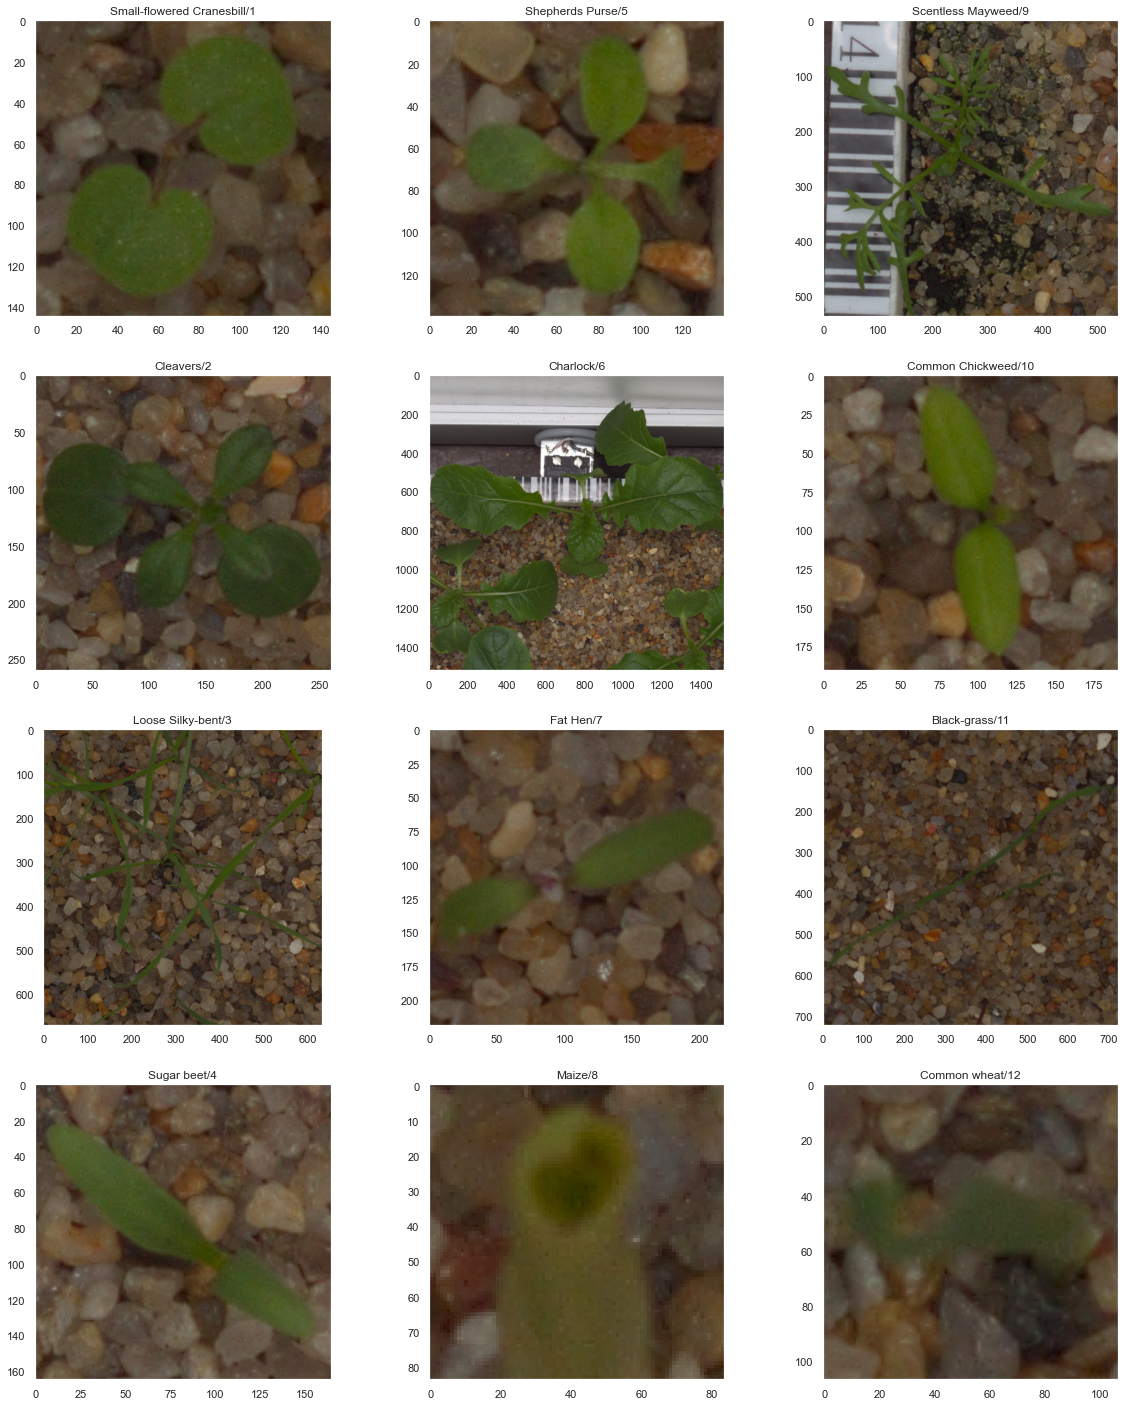

In [7]:
fig, ax = plt.subplots(4,3,figsize=(20,25))

for m in range(4):
    for n in range(3):
        folder = subfolders[m+n*4]
        files = listdir(base_path + folder + "/")
        image = imread(base_path + folder + "/" + files[0])
        ax[m,n].imshow(image)
        ax[m,n].grid(False)
        ax[m,n].set_title(folder + "/" + str(m+n*4+1))

We can see clearly by the size of the stones that the **images of the plants were taken with different distances the the ground**. This procedure is **coupled to the growth state of the plant but also to the species** themselves. For example, the most images of Scentless Mayweed were taken at an early growth state where the camera was close to the stones. In contrast many images of black grass and maize were taken with a high distance to the ground to cover all parts of a single plant. **This leads to a unconscious target leakage as one can infer the the species type by looking at the size of the stones in the background**. 

# How can we bypass the target leakage?


We can **get rid of the leakage by removing the pebble stones**. Is it important to scale down large plants of later growth states to small ones? In my opinion it's not. For each species we have several different kind of plants that are related to its growth state. Maize for example might look completely different at early growth states compared to later ones. This is tricky as we allow the appearance of our species to vary a lot within one class. 

## About RGB, HSV and LAB

### RGB

* The RGB is an additive color space.
* Creating any color by mixing the three primitive additives Red, Green and Blue.
* A pixel with 3 channels contains information of (red, green, blue) light with values between 0 and 255. 
* Given all values equal to 0 maps to black, all values 255 maps to white.


<img src="https://upload.wikimedia.org/wikipedia/commons/0/03/RGB_farbwuerfel.jpg" width="600px"> 
<a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=13754">Link</a>

## HSV

* **Colors of each hue** follow the radius on the circle. It's values have an angular dimension starting with the red primary at 0°, passing the green primary at 120° and the blue primary at 240° and finally ending up with red again at 360°.
* The **vertical axis describes the gray scale** ranging from black (0) to white (1). 
* The **horizontal axis covers the saturation** of the color that can be reduced by tinting with white from 1 to 0.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f1/HSV_cone.jpg" width="300px"> 

Image created by <a href="https://en.wikipedia.org/wiki/User:Wapcaplet" class="extiw" title="en:User:Wapcaplet">Wapcaplet</a> - From en wiki, <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=308191">Link</a>

## LAB

* The LAB colorspace consists of three values describing the lightness (L) as well as values A and B that describe a colorful plane. 
* Lightness has values from black (0) to white (100)
* A holds colors from green to red. (−128 to 127)
* B holds colors from blue to yellow. (−128 to 127)

<img src="https://upload.wikimedia.org/wikipedia/commons/7/7d/CIELAB_color_space_front_view.png" width="300px"> 

Image created by <a href="//commons.wikimedia.org/wiki/User:Farbenprofi" title="User:Farbenprofi">Holger Everding</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=38366969">Link</a>

## Extracting the pebble stones 
For our eyes it's easy to detect the plant by its green color but given RGB numerical values it's not. If we take a look at individual color channels we can see that many pebble stones have almost the same value as the plant. This problem could be even more worse for other species than Fat Hen. 

In [8]:
example_path = base_path + "Sugar beet/27.png" 

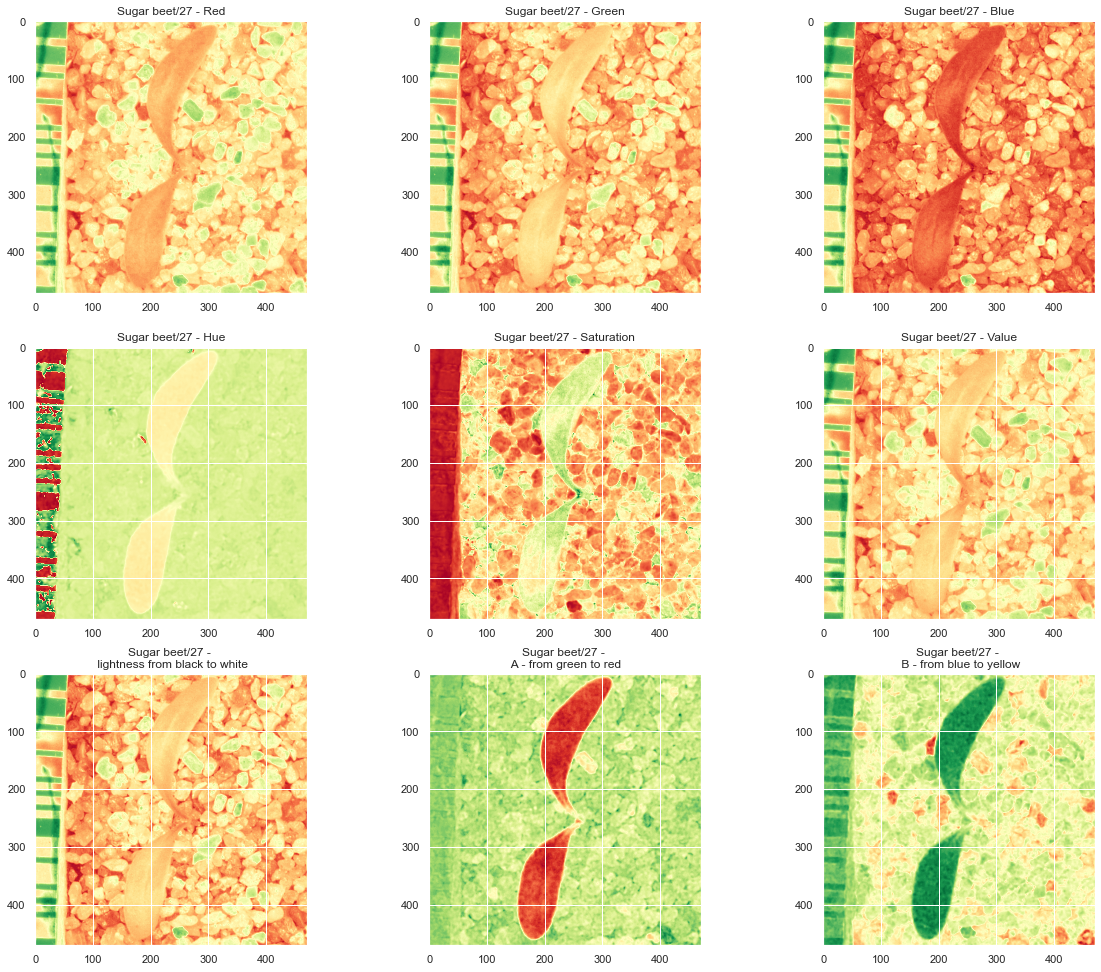

In [9]:
fig,ax = plt.subplots(3,3,figsize=(20,17))

titles = [["Red", "Green", "Blue"],
         ["Hue", "Saturation", "Value"],
         ["\n lightness from black to white", "\n A - from green to red", "\n B - from blue to yellow"]]
pil_image = Image.open(example_path)
np_image = np.array(pil_image)
image_hvs = cv2.cvtColor(np_image, cv2.COLOR_BGR2HSV)
image_lab = cv2.cvtColor(np_image, cv2.COLOR_BGR2LAB)

for n in range(3):
    ax[0,n].imshow(np_image[:,:,n], cmap="RdYlGn")
    ax[0,n].grid(False)
    ax[0,n].set_title("Sugar beet/27" + " - " + titles[0][n]);
    ax[1,n].imshow(image_hvs[:,:,n], cmap="RdYlGn")
    ax[1,n].set_title("Sugar beet/27" + " - " + titles[1][n]);
    ax[2,n].imshow(image_lab[:,:,n], cmap="RdYlGn")
    ax[2,n].set_title("Sugar beet/27" + " - " + titles[2][n]);
plt.savefig("Colorspace", dpi=500)

In the LAB colorspace the situation looks best! :-) Let's use the A-Channel to segment the plants. 

## Segmentation with thresholds

We have seen that the first channel of the LAB space that decribes the colors from green to red is sufficient to extract the plant information. This is good as we only need one threshold to compute a mask that allows us to perform the segmentation. After applying this concept we can see that there are still some stone speckels left. We can get rid of them by using a technique called [opening](https://en.wikipedia.org/wiki/Opening_%28morphology%29).

The method first sets a pixel ij to the minimum of its neighborhood pixels (in our case given by a disk with radius R centered at the pixel ij) followed by the opposite operation to the maximum of its neighborhood. This way we remove all small speckles and then restore the boundary values of the plants that have been set to the minimum as well. 

In [10]:
my_threshold = 121
my_radius = 2

Create the mask by thresholding the A-Channel and fine-tune the mask by an opening:

In [11]:
def get_mask(image, threshold, radius):
    mask = np.where(image < threshold, 1, 0)
    selem = disk(radius)
    mask = closing(mask, selem)
    return mask

Multiply all channels by the mask to set the pebble stones to zero while retaining the plants:

In [12]:
def segment_plant(np_image, threshold, radius):
    image_lab = cv2.cvtColor(np_image, cv2.COLOR_BGR2LAB)
    mask = get_mask(image_lab[:,:,1], threshold, radius)
    masked_image = np_image.copy()
    for n in range(3):
        masked_image[:,:,n] = np_image[:,:,n] * mask
    return masked_image

And here is how the result looks like:

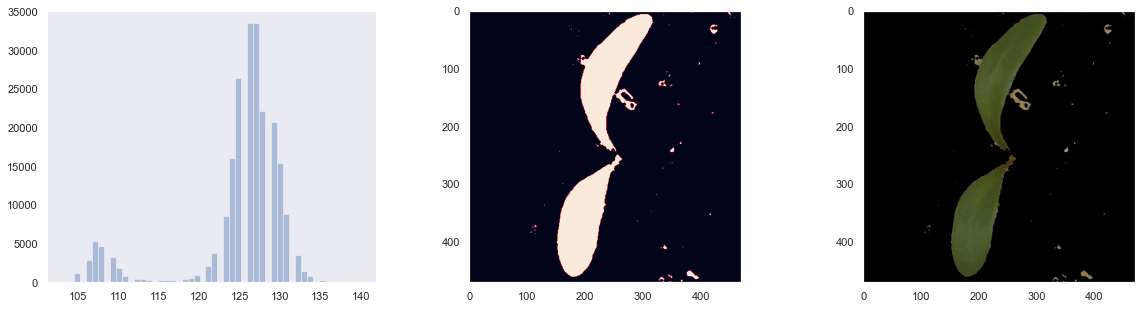

In [13]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(image_lab[:,:,1].flatten(), ax=ax[0], kde=False)
mask = get_mask(image_lab[:,:,1], my_threshold, my_radius)
ax[1].imshow(mask);
ax[2].imshow(segment_plant(np_image, my_threshold, my_radius))
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

You can see that a threshold of 120 is already sufficient to solve this task. Furthermore it seems to be a good choice for the other species as well:

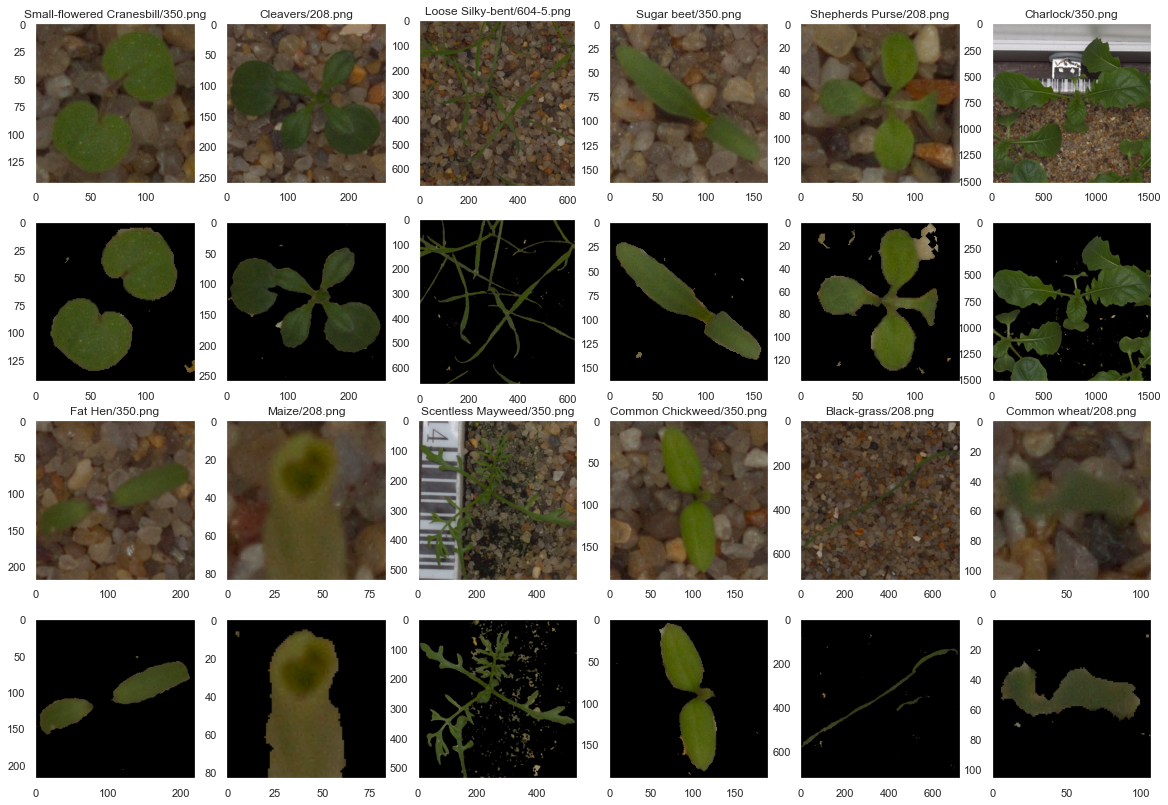

In [14]:
fig, ax = plt.subplots(4,6,figsize=(20,14))

for m in range(6):
    folder = subfolders[m]
    files = listdir(base_path + folder + "/")
    image = np.array(Image.open(base_path + folder + "/" + files[0]))
    ax[0,m].imshow(image)
    ax[1,m].imshow(segment_plant(image, my_threshold, my_radius))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[0,m].set_title(folder + "/" + files[0])
    
    folder = subfolders[m+6]
    files = listdir(base_path + folder + "/")
    image = np.array(Image.open(base_path + folder + "/" + files[0]))
    ax[2,m].imshow(image)
    ax[3,m].imshow(segment_plant(image, my_threshold, my_radius))
    ax[2,m].grid(False)
    ax[3,m].grid(False)
    ax[2,m].set_title(folder + "/" + files[0])

## Segmentation with U Net

In [ ]:
### u-net model preparation
image from https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

![image](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# Building up the workflow

Ok, let's start with the modelling part. As we need to perform a custom data preprocessing step I would like to work with pytorch. In my opinion it seems to offers a nice way to include your own preprocessing operations. 

## Preprocessing

### Plant segmentation

We only need to write our segmentation as a callable class. This way we don't need to pass our parameters every time and we can include our method in a sequence of pytorch transform operations:

In [27]:
class SegmentPlant(object):
    
    def __call__(self, image):
        np_image = np.array(image)
        image = segment_plant(np_image, my_threshold, my_radius)
        pil_image = Image.fromarray(image)
        return pil_image

### Further preprocessing steps

* Besides the plant segmentation we need to resize our images to a common size. 
* As we have a few images that are not quadratic we also need to perform a crop around the image center where we usually expect the plant to be located. 
* In addition we should add further data augmentation techniques during training of our network. This includes random rotations, flips as well as random zooming.
* The final step is given by an appropriate normalization of the images that suites to the pretrained model of our choice. 

In [28]:
class RandomZoom(object):
    
    def __call__(self, image):
        zoom_factor = np.random.uniform(0.7, 1.2)
        height = image.size[0]
        width = image.size[1]
        new_size = (np.int(zoom_factor*height), np.int(zoom_factor*width))
        return transforms.Resize(new_size)(image)

In [29]:
def my_transform(key="train", plot=False):
    train_sequence = [RandomZoom(),
        transforms.Resize(size=256),
            transforms.CenterCrop(224),
            SegmentPlant(),
            transforms.RandomAffine(30),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()]
    val_sequence = [transforms.Resize(size=256),
            transforms.CenterCrop(224),
            SegmentPlant()]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

Let's have a look at the preprocessed images without normalization:

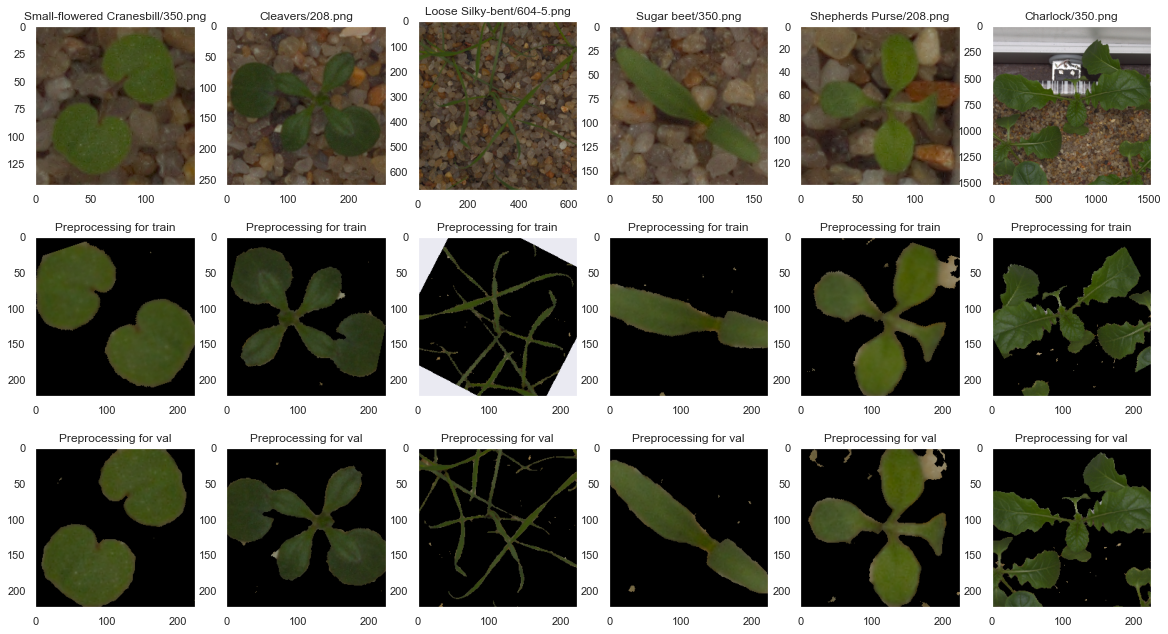

In [30]:
fig, ax = plt.subplots(3,6,figsize=(20,11))

train_transform = my_transform(key="train", plot=True)
val_transform = my_transform(key="val", plot=True)

for m in range(6):
    folder = subfolders[m]
    files = listdir(base_path + folder + "/")
    image = Image.open(base_path + folder + "/" + files[0])
    ax[0,m].imshow(image)
    transformed_img = train_transform(image)
    ax[1,m].imshow(transformed_img)
    ax[2,m].imshow(val_transform(image))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[2,m].grid(False)
    ax[0,m].set_title(folder + "/" + files[0])
    ax[1,m].set_title("Preprocessing for train")
    ax[2,m].set_title("Preprocessing for val")

This looks as expected! There is just resizing and segmentation for the validation data and further image augmentations like random zoom, rotations and cropping for the training data.

## Dataset and Dataloader

Pytorch makes it really easy to prepare and load your data by writing your own dataset. In our case we use a pandas dataframe to extract the target and to load the related image given its name. Furthermore we pass our transform methods to transform with respect to "val" and "train":

In [31]:
class SeedlingsDataset(Dataset):
    
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        image_path = self.root_dir + self.states.species.values[idx] + "/" 
        image_path += self.states.image_name.values[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
         
        target = self.states.target.values[idx]
        return {"image": image, "label": target}

## Validation strategy

As our dataset is small we like to go with a traditional split of our data into: 60% training data,20 % dev data and 20% test data. As we found class imbalance in our target distribution, we should stratify the split on our target data. This way we ensure that we have similar distributions in train, dev and test data. 

In [32]:
# Obtain the training data by splitting into 60% train and 40% for the next split
train_idx, sub_test_idx = train_test_split(plantstate.index.values,
                                           test_size=0.4,
                                           random_state=2019,
                                           stratify=plantstate.target.values)

# Split the residual 40% into two parts (each 20% of the original data): 
dev_idx, test_idx = train_test_split(sub_test_idx,
                                     test_size=0.5,
                                     random_state=2019,
                                     stratify=plantstate.loc[sub_test_idx, "target"].values)

Now we have to setup our datasets for each data chunk and pytorch dataloaders:

In [33]:
BATCH_SIZE = 32

In [34]:
train_df = plantstate.loc[train_idx].copy()
dev_df = plantstate.loc[dev_idx].copy()
test_df = plantstate.loc[test_idx].copy()

train_dataset = SeedlingsDataset(base_path, train_df, transform=my_transform(key="train"))
dev_dataset = SeedlingsDataset(base_path, dev_df, transform=my_transform(key="val"))
test_dataset = SeedlingsDataset(base_path, test_df, transform=my_transform(key="val"))

image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

print(len(train_dataset), len(dev_dataset), len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

dataloaders = {"train": train_dataloader, "dev": dev_dataloader, "test": test_dataloader}

3323 1108 1108


## Transfer learning

We will use a model that was already trained to classify a broad range of daily objects on the imagenet dataset to solve the new task to classify plant species. This method is called transfer learning and it provides many advantages over training from skretch: 

* The first layers of convolutional neural networks often extract basic features like edges, textures and abstract patters. Only the very depth layers extract information that can be related to parts and objects. If you like have a nice introduction to it, take a look at [feature visualizations](https://distill.pub/2017/feature-visualization/) of [Christopher Colahs Blog](https://colah.github.io/about.html).  
* By only removing the last fully connected layer and building some new densely connected layers we still have enough parameters to train a new task on. Usually the last fully connected layers contain a large proportion of trainable parameters due to their high connectiviy. 
* As we have already trained parameters for the feature extraction we may be able to bypass the high demand for training data of neural networks that we would need to prevent overfitting. 

Let's go! :-)

In [35]:
def train_loop(model, criterion, optimizer, scheduler=None, num_epochs = 10, lam=0.0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)
    
    running_loss_dict = {"train": [], "dev": [], "test": []}
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ["train", "dev", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)
                        
                        #loss += l2_reg
            
                        optimizer.step()
                        
                        
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    if scheduler is not None:
                        scheduler.step()
                
                counter += 1
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter*dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, running_loss_dict

I have added some pretrained models for pytorch. I have decided to start simple by working with resnet18 but other models may be more performant either to solve this task with respect to a desired evaluation metric or with respect to speed performance during inference.

In [36]:
listdir("../input/pretrained-pytorch-models/")

['resnet18-5c106cde.pth']

If the GPU is available we like to use it:

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

On top of resnet as a feature extractor it makes sense to add some more fully connected layers. Due to their high connectivity they hold a large portion of trainable parameters that allow the network to adapt to the new task of plant species recognition:

In [47]:
run_training =  True
model = torchvision.models.resnet18(pretrained=False)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


The distribution of target plant species shows a class imbalance. A simple approach to start with is by setting class weights that make seldom classes more relevant for the loss (and gradients) than common classes.   

In [48]:
weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())    
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6059, 0.7608, 0.8573, 0.6470, 0.9961, 1.3777, 1.4968, 1.8218, 1.0218,
        0.8003, 1.6885, 1.7982], device='cuda:0')


In our case we can use a so called weighted cross entropy loss. The species with higher weights contribute more to our measurement of prediction errors. By minimizing this loss function we enforce our model to learn the appropriate parameters to solve our species classification task:

In [49]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.fc.parameters(), lr=0.09, momentum=0.9)
scheduler = CyclicLR(optimizer, base_lr=0.01, max_lr=0.09)

In [50]:
run_training = True
if run_training:
    model, loss_dict, running_loss_dict = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = 10)
    
    if device == "cpu":
        OUTPUT_PATH += ".pth"
    else:
        OUTPUT_PATH += "_cuda.pth"
        
    torch.save(model.state_dict(), OUTPUT_PATH)
    
    losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
    losses_df.loc[:, "dev"] = loss_dict["dev"]
    losses_df.loc[:, "test"] = loss_dict["test"]
    losses_df.to_csv("losses_segmented_seedlings.csv", index=False)
    
    running_losses_df = pd.DataFrame(running_loss_dict["train"], columns=["train"])
    running_losses_df.loc[0:len(running_loss_dict["dev"])-1, "dev"] = running_loss_dict["dev"]
    running_losses_df.loc[0:len(running_loss_dict["test"])-1, "test"] = running_loss_dict["test"]
    running_losses_df.to_csv("running_losses_segmented_seedlings.csv", index=False)
else:
    if device == "cpu":
        MODEL_PATH += ".pth"
    else:
        MODEL_PATH += "_cuda.pth"
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    
    losses_df = pd.read_csv(LOSSES_PATH + "losses_segmented_seedlings.csv")
    running_losses_df = pd.read_csv(LOSSES_PATH + "running_losses_segmented_seedlings.csv")

Epoch 0/9
----------


/home/indiano/anaconda3/envs/plantdisease/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 1.2744 Acc: 0.5964



dev Loss: 0.5261 Acc: 0.7726



test Loss: 0.4259 Acc: 0.8312

Epoch 1/9
----------



train Loss: 0.7055 Acc: 0.7349



dev Loss: 0.4558 Acc: 0.8096



test Loss: 0.4285 Acc: 0.8412

Epoch 2/9
----------



train Loss: 0.7088 Acc: 0.7439



dev Loss: 0.5430 Acc: 0.7834



test Loss: 0.4481 Acc: 0.8213

Epoch 3/9
----------



train Loss: 0.6418 Acc: 0.7593



dev Loss: 0.4758 Acc: 0.8222



test Loss: 0.3950 Acc: 0.8384

Epoch 4/9
----------



train Loss: 0.6166 Acc: 0.7707



dev Loss: 0.4327 Acc: 0.8195



test Loss: 0.3897 Acc: 0.8430

Epoch 5/9
----------



train Loss: 0.6139 Acc: 0.7749



dev Loss: 0.3876 Acc: 0.8403



test Loss: 0.3418 Acc: 0.8520

Epoch 6/9
----------



train Loss: 0.5530 Acc: 0.7954



dev Loss: 0.4393 Acc: 0.8312



test Loss: 0.3859 Acc: 0.8493

Epoch 7/9
----------



train Loss: 0.5580 Acc: 0.7881



dev Loss: 0.4628 Acc: 0.8150



test Loss: 0.4288 Acc: 0.8276

Epoch 8/9
----------



train Loss: 0.5567 Acc: 0.7948



dev Loss: 0.3821 Acc: 0.8448



test Loss: 0.3125 Acc: 0.8718

Epoch 9/9
----------



train Loss: 0.5410 Acc: 0.7981



dev Loss: 0.4608 Acc: 0.8258



test Loss: 0.3326 Acc: 0.8637

Training complete in 20m 58s
Best val Acc: 0.844765


# Results - How good can we classify plant species?

### Loss convergence

After training, we should take a look at the train, dev and test losses of our splitted dataset:

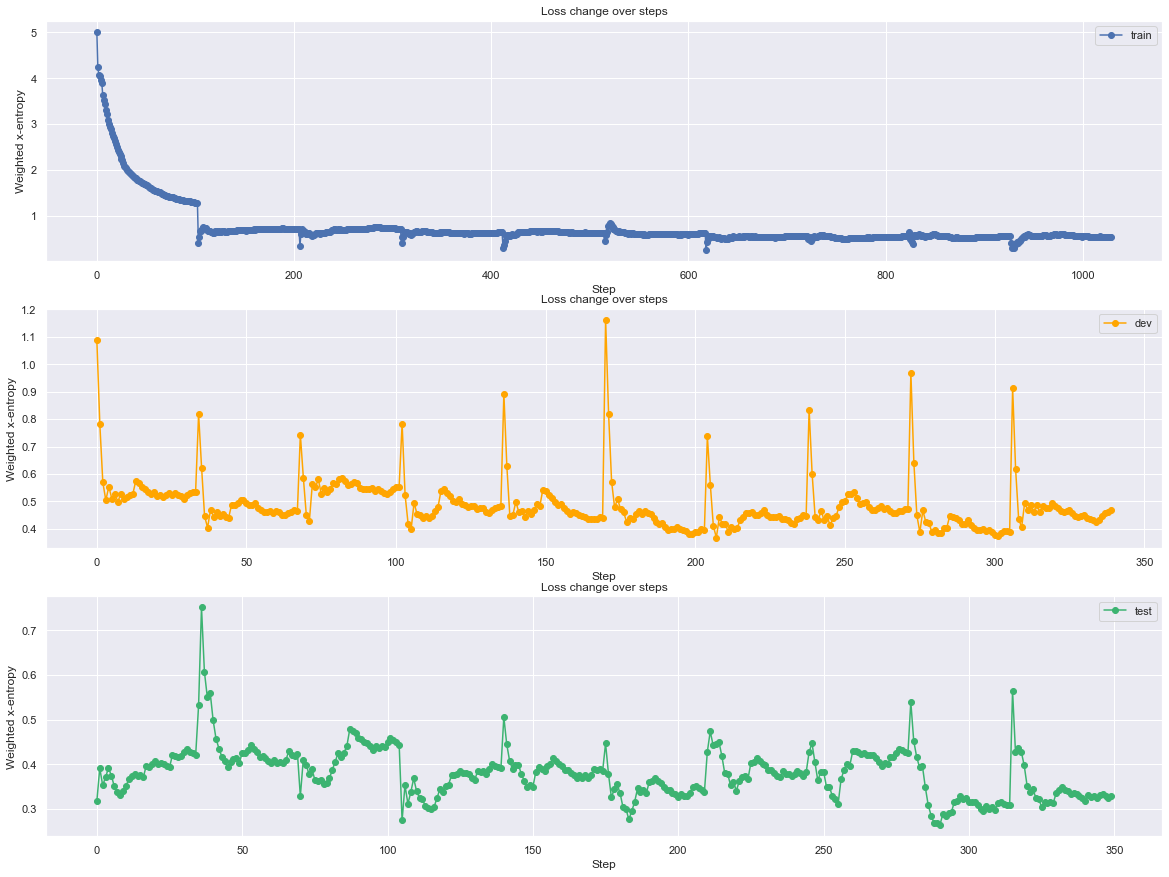

In [51]:
fig, ax = plt.subplots(3,1,figsize=(20,15))

ax[0].plot(running_losses_df["train"], '-o', label="train")
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Weighted x-entropy")
ax[0].set_title("Loss change over steps")
ax[0].legend();

ax[1].plot(running_losses_df["dev"], '-o', label="dev", color="orange")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Weighted x-entropy")
ax[1].set_title("Loss change over steps")
ax[1].legend();

ax[2].plot(running_losses_df["test"], '-o', label="test", color="mediumseagreen")
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Weighted x-entropy")
ax[2].set_title("Loss change over steps")
ax[2].legend();

* Each step belongs to one computed batch in this plot. 
* We can clearly see how the training loss converges and that it shows jumps after each epoch.
* The same can be observed for the dev and test data.

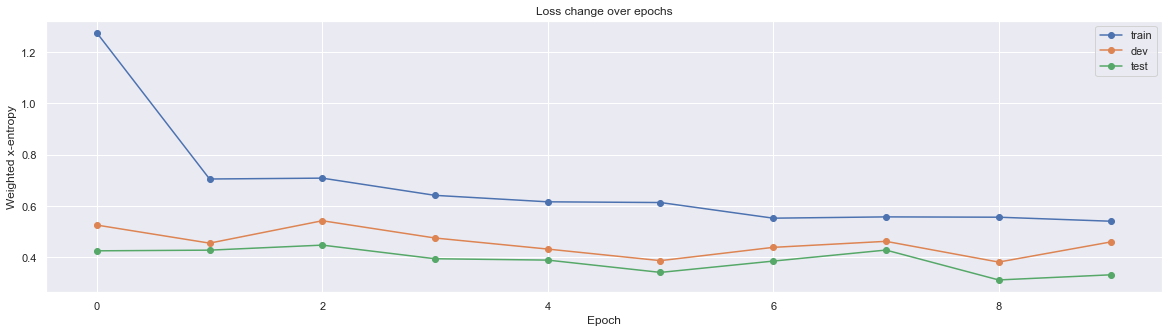

In [52]:
plt.figure(figsize=(20,5))
plt.plot(losses_df["train"], '-o', label="train")
plt.plot(losses_df["dev"], '-o', label="dev")
plt.plot(losses_df["test"], '-o', label="test")
plt.xlabel("Epoch")
plt.ylabel("Weighted x-entropy")
plt.title("Loss change over epochs");
plt.legend();

* Looking at the loss per epoch, we can see that the model learns to make better predictions at least until epoch 5. After then the dev and test losses show a slight increase again. This could indicate overfitting but due to the fact that both losses decrease again it's not obvious and clear. 

### Predictions and confusion

Let's take a look at some individual predictions and on the confusion matrix:

In [53]:
dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted"])
test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted"])

plt.ion()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int)
    predictions_df = predictions_df.dropna()
    return predictions_df

Looks fine. Let's go into more details!

#### Dev data

In [54]:
import warnings
warnings.filterwarnings("ignore")

species_map = {0: "Black-grass",
               1: "Charlock",
               2: "Cleavers",
               3: "Common Chickweed",
               4: "Common wheat",
               5: "Fat Hen",
               6: "Loose Silky-bent",
               7: "Maize",
               8: "Scentless Mayweed",
               9: "Shepherd's Purse",
               10: "Small-flowered Cranesbill",
               11: "Sugar beet"}

dev_predictions = evaluate_model(model, dev_predictions, "dev")
dev_predictions.loc[:,"true"] = dev_predictions.loc[:, "true"].astype(np.int)
dev_predictions.loc[:, "predicted"] = dev_predictions.loc[:, "predicted"].astype(np.int)
dev_predictions.loc[:, "true species"] = dev_predictions.loc[:, "true"].map(species_map)
dev_predictions.loc[:, "predicted species"] = dev_predictions.loc[:, "predicted"].map(species_map)
dev_predictions.head()

true  predicted      true species predicted species
0     3          3  Common Chickweed  Common Chickweed
1     1          1          Charlock          Charlock
2     6          6  Loose Silky-bent  Loose Silky-bent
3     5          5           Fat Hen           Fat Hen
4     6          6  Loose Silky-bent  Loose Silky-bent

In [55]:
accuracy_score(dev_predictions.true.values, dev_predictions.predicted.values)

0.8602941176470589

We were able to classify 87 % of the classes in the dev data.

#### Test data

In [56]:
test_predictions = evaluate_model(model, test_predictions, "test")
test_predictions.loc[:,"true"] = test_predictions.loc[:, "true"].astype(np.int)
test_predictions.loc[:, "predicted"] = test_predictions.loc[:, "predicted"].astype(np.int)
test_predictions.loc[:, "true species"] = test_predictions.loc[:, "true"].map(species_map)
test_predictions.loc[:, "predicted species"] = test_predictions.loc[:, "predicted"].map(species_map)
test_predictions.head()

true  predicted      true species  predicted species
0     9          9  Shepherd's Purse   Shepherd's Purse
1     9          8  Shepherd's Purse  Scentless Mayweed
2     5          5           Fat Hen            Fat Hen
3     9          8  Shepherd's Purse  Scentless Mayweed
4     5          5           Fat Hen            Fat Hen

In [57]:
accuracy_score(test_predictions.true.values, test_predictions.predicted.values)

0.871841155234657

With close to 85 % this accuracy of the test data is similar to the dev data.

### Single accuracies and confusion matrix

To improve the model and the workflow we need to take a look at single acurracy scores and on the confusion matrix:

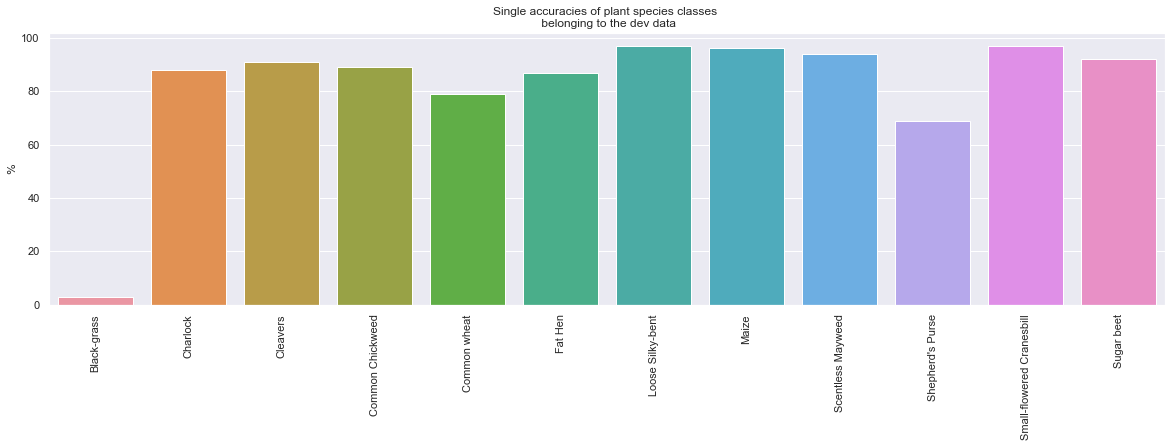

In [58]:
single_accuracies = []
names = []

for key, val in species_map.items():
    y_pred = dev_predictions[dev_predictions.true==key].predicted.values
    y_true = dev_predictions[dev_predictions.true==key].true.values
    
    single_accuracies.append(np.int(accuracy_score(y_true,y_pred)*100))
    names.append(val)

plt.figure(figsize=(20,5))
sns.barplot(x=names, y=single_accuracies)
plt.xticks(rotation=90);
plt.ylabel("%")
plt.title("Single accuracies of plant species classes \n belonging to the dev data");

### Insights

* We failed to predict black-grass correctly. Furthermore we observe lower accuracies for common wheat and Shepherd's Purse. 
* Luckily we also observe a lot of plants with high accuracy scores > 95 %. 
* To significantly improve our model we need to find out why black-grass was misclassified that often and why some other plants show low scores.

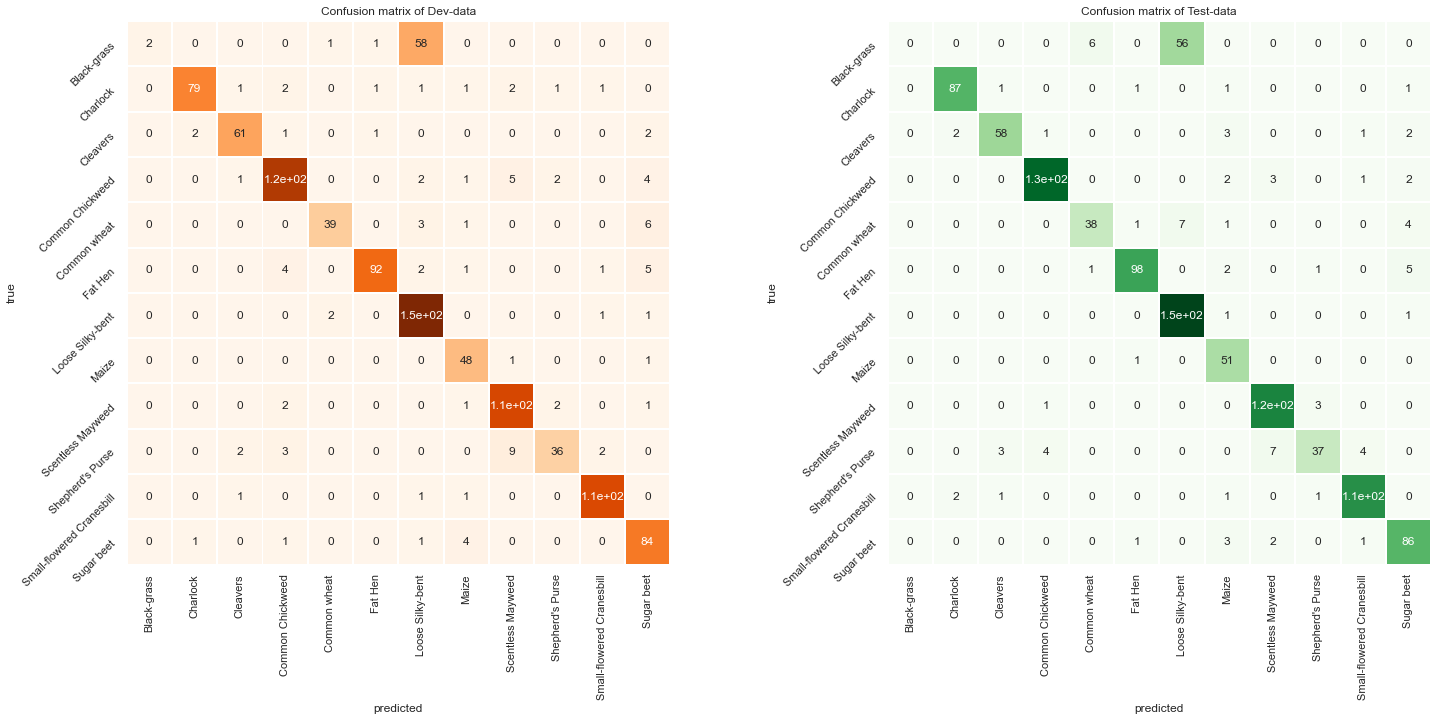

In [59]:
dev_confusion = confusion_matrix(dev_predictions["true species"].values, dev_predictions["predicted species"].values)
test_confusion = confusion_matrix(test_predictions["true species"].values, test_predictions["predicted species"].values)

fig, ax = plt.subplots(1,2,figsize=(25,10))
sns.heatmap(dev_confusion, annot=True, cmap="Oranges", square=True, cbar=False, linewidths=1, ax=ax[0]);
sns.heatmap(test_confusion, annot=True, cmap="Greens", square=True, cbar=False, linewidths=1, ax=ax[1]);
ax[0].set_title("Confusion matrix of Dev-data");
ax[0].set_xticklabels([name for val, name in species_map.items()], rotation=90)
ax[0].set_yticklabels([name for val, name in species_map.items()], rotation=45)
ax[0].set_xlabel("predicted")
ax[0].set_ylabel("true")
ax[1].set_title("Confusion matrix of Test-data");
ax[1].set_xticklabels([name for val, name in species_map.items()], rotation=90)
ax[1].set_yticklabels([name for val, name in species_map.items()], rotation=45);
ax[1].set_xlabel("predicted")
ax[1].set_ylabel("true");
plt.savefig("Confusion", dpi=200)

### Insights

* Most of the time black-grass is misclassified as loose-silky-bent.
* All other classes do not show a major class that occurs as a misclassification counterpart. 

Ignoring the black-grass/loose-silky-bent classes, how good is the score?

In [60]:
accuracy_score(dev_predictions[dev_predictions.true.isin([6,0])==False].true.values,
               dev_predictions[dev_predictions.true.isin([6,0])==False].predicted.values)

0.8993135011441648

### Why is black-grass misclassified and can we solve the problem easily?

Let's take a look again at the plants and how they are prepared for training:

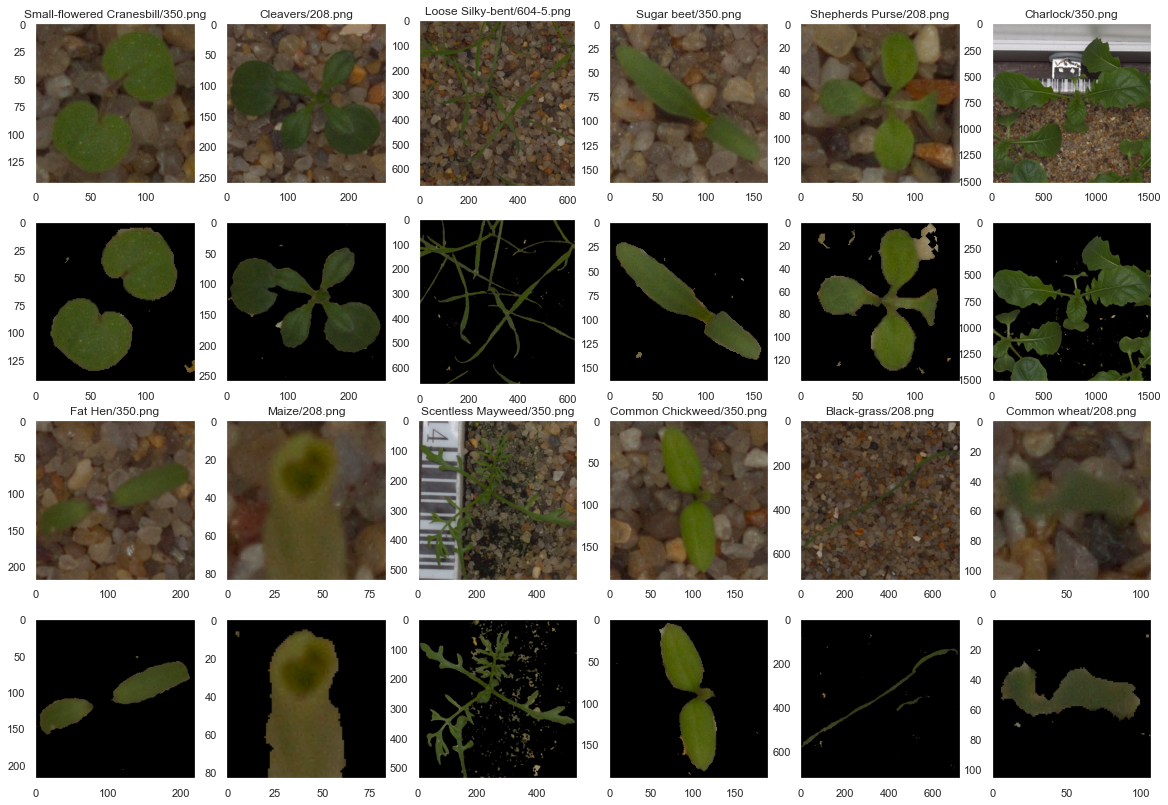

In [61]:
fig, ax = plt.subplots(4,6,figsize=(20,14))

for m in range(6):
    folder = subfolders[m]
    files = listdir(base_path + folder + "/")
    image = np.array(Image.open(base_path + folder + "/" + files[0]))
    ax[0,m].imshow(image)
    ax[1,m].imshow(segment_plant(image, my_threshold, my_radius))
    ax[0,m].grid(False)
    ax[1,m].grid(False)
    ax[0,m].set_title(folder + "/" + files[0])
    
    folder = subfolders[m+6]
    files = listdir(base_path + folder + "/")
    image = np.array(Image.open(base_path + folder + "/" + files[0]))
    ax[2,m].imshow(image)
    ax[3,m].imshow(segment_plant(image, my_threshold, my_radius))
    ax[2,m].grid(False)
    ax[3,m].grid(False)
    ax[2,m].set_title(folder + "/" + files[0])

### Insights on How-To-Improve

* Black-grass, losse-silky bent and common wheat look very similar after segmentation.
* As we used random zoom as image augmentation technique it might occur that the classification challenge had become even harder.The size of the plants could be an important feature that we have destroyed this way. Perhaps black-grass always looks a bit more narrow than loose-silky-bent. Then we could improve by removing the zoom effects in image augmentations. 
* Furthermore we have several artifacts on the leave edges that are related to image closing and plant segmentation. To improve the classification for all plants, this step has to be reworked.
* We should add Gaussian blurr as image augmentation technique as the image resolution differs from image to image and from growth state to growth state.

After improving the model by adjusting image preprocessing and augmentation one should play with model complexity and the chosen number of iterations as well as the learning rate. 

# Conclusion

The analysis showed how deep learning can be of great help to recognize plant species. It covered the whole cycle from data exploration, preprocessing, feature engineering, machine learning modelling and result analysis. The workflow acts as a baseline that can be improved iteratively by repeating the different steps and adjusting single aspects that are likely to improve the results. 